### Chargement des librairies

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

Chargement des données

In [2]:
titanic = pd.read_csv("titanic.csv",decimal=",")

Visualisation des premières données

In [3]:
titanic.head()

,Survived,Sex,Age,Class,Embarked,Fare,Name
0,0,Male,22.0,3,Southampton,7.2500,"Braund, Mr. Owen Harris"
1,1,Female,38.0,1,Cherbourg,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,1,Female,26.0,3,Southampton,7.9250,"Heikkinen, Miss. Laina"
3,1,Female,35.0,1,Southampton,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,0,Male,35.0,3,Southampton,8.0500,"Allen, Mr. William Henry"


Redéfinition des types de données

In [321]:
titanic['Age'] = titanic['Age'].astype(float)
titanic['Fare'] = titanic['Fare'].astype(float)
titanic['Class'] = titanic['Class'].astype(int)

Exploration des données

In [4]:
titanic.count()

Survived    891
Sex         891
Age         891
Class       891
Embarked    891
Fare        891
Name        891
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012C73FAF7F0>,
      dtype=object)

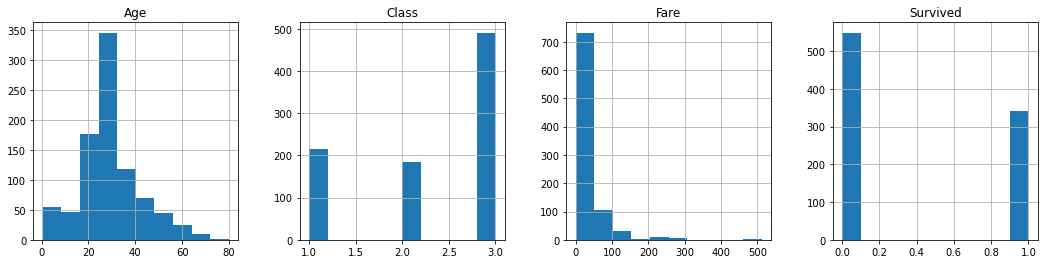

In [5]:
titanic.hist(column=['Survived','Age','Class','Fare'],layout=(1,4),figsize=(18,4))

<function matplotlib.pyplot.show(*args, **kw)>

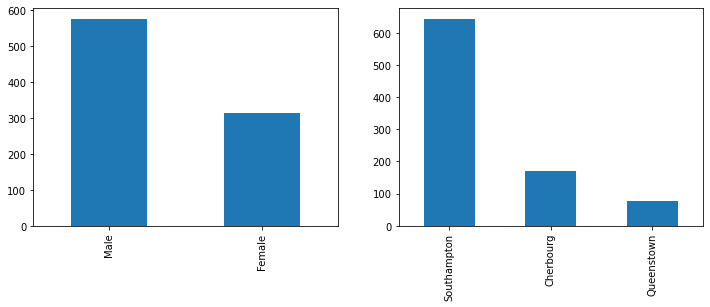

In [324]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
titanic['Sex'].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
titanic['Embarked'].value_counts().plot(kind='bar')
plt.show

- Transormation des variables categorielles en variable dummy
- Suppression des noms

In [6]:
sex=pd.get_dummies(titanic["Sex"])
embarked=pd.get_dummies(titanic["Embarked"])
titanic=pd.concat([titanic,sex,embarked],axis=1)
titanic=titanic.drop(['Sex','Embarked','Name'],axis=1)

In [326]:
titanic.head()

,Survived,Age,Class,Fare,Female,Male,Cherbourg,Queenstown,Southampton
0,0,22.0,3,7.2500,0,1,0,0,1
1,1,38.0,1,71.2833,1,0,1,0,0
2,1,26.0,3,7.9250,1,0,0,0,1
3,1,35.0,1,53.1000,1,0,0,0,1
4,0,35.0,3,8.0500,0,1,0,0,1


### Représentation des facteurs de survie

Les fonctions suivantes permettent de représenter des points en brouillant leur coordonnées légèrement afin qu'un point sur-représenté soit plus épais

In [7]:
def rand_jitter(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

Text(0.5, 1.0, 'Southampton')

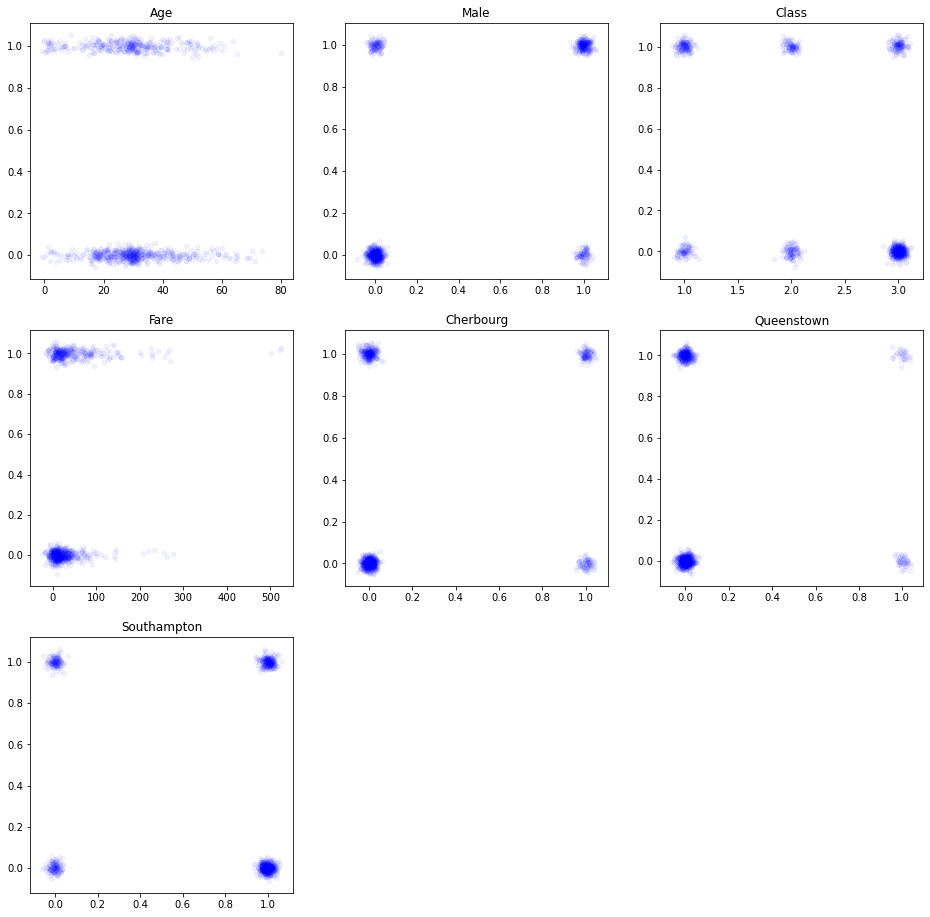

In [328]:
plt.figure(figsize=(16,16))
plt.subplot(3,3,1)
jitter(titanic['Age'],titanic['Survived'],alpha=0.05)
plt.title('Age')
plt.subplot(3,3,2)
jitter(titanic['Female'],titanic['Survived'],alpha=0.05)
plt.title('Male')
plt.subplot(3,3,3)
jitter(titanic['Class'],titanic['Survived'],alpha=0.05)
plt.title('Class')
plt.subplot(3,3,4)
jitter(titanic['Fare'],titanic['Survived'],alpha=0.05)
plt.title('Fare')
plt.subplot(3,3,5)
jitter(titanic['Cherbourg'],titanic['Survived'],alpha=0.05)
plt.title('Cherbourg')
plt.subplot(3,3,6)
jitter(titanic['Queenstown'],titanic['Survived'],alpha=0.05)
plt.title('Queenstown')
plt.subplot(3,3,7)
jitter(titanic['Southampton'],titanic['Survived'],alpha=0.05)
plt.title('Southampton')


### Choix des colonnes d'apprentissage

In [12]:
Xinit=titanic.drop(['Survived','Male','Cherbourg','Queenstown','Southampton'],axis=1)
Yinit=titanic['Survived']
print([Xinit.head(),Yinit.head()])

[    Age  Class     Fare  Female
0  22.0      3   7.2500       0
1  38.0      1  71.2833       1
2  26.0      3   7.9250       1
3  35.0      1  53.1000       1
4  35.0      3   8.0500       0, 0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64]


- Extraction des 600 premiers individus
- On garde le reste pour tester le modèle

In [13]:
X=Xinit.iloc[:600]
Y=Yinit.iloc[:600]
n=len(X)
d=len(X.iloc[1])
X_test=Xinit.iloc[600:]
Y_test=Yinit.iloc[600:]
n_test=len(X_test)

Fonction à optimiser et gradient

In [14]:
def f(b,W):
    XdotW=np.dot(X,W)
    B=[b for i in range(len(X))]
    bpXdotW=B+XdotW
    return sum([np.log(1+np.exp(-(bpXdotW[i])))+(1-Y.iloc[i])*(bpXdotW[i]) for i in range(n)])  

def df(b,W):
    XdotW=np.dot(X,W)
    B=[b for i in range(len(X))]
    ebpXdotW=np.exp(-(B+XdotW))
    L=[sum([-ebpXdotW[i]/(1+ebpXdotW[i])+1-Y.iloc[i] for i in range(len(X))])]
    for j in range(d):
        L.append(sum([-X.iloc[i][j]*ebpXdotW[i]/(1+ebpXdotW[i])+X.iloc[i][j]*(1-Y.iloc[i]) for i in range(n)]))
    return L

### Algorithme

In [15]:
def descente(gradf,b=0,W=np.ones(d),tau=0.0001,tolerance=1e-6,Nbiterations=1000):
    L=[]
    for i in range(Nbiterations):
        g = gradf(b,W)
        if np.linalg.norm(g)< tolerance:
            print('L\'algorithme a convergé.\n Solution atteinte:\n b=',b,'\n W=',W,'\n Gradient obtenu :\n',g)
            return [b,W]        
        #L.append([b,W])        
        b=b-tau*g[0]
        W=[W[j]-tau*g[j+1] for j in range(d)]
    print('L\'algorithme n\'a pas convergé.\n Solution atteinte:\n b=',b,'\n W=',W,'\n Gradient obtenu :\n',g)    
    return [b,W]

### Calcul de la solution

Départ : $S=(b,[w_1,w_2,\ldots,w_d])=(1,[1,\ldots,1])$

In [17]:
S=[1,np.ones(d)]

Descente de gradient à partir de S (à répeter plusieurs fois si nécessaire)

In [18]:
S=descente(df,S[0],S[1],1e-4,1,10)

L'algorithme n'a pas convergé.
 Solution atteinte:
 b= 0.9303888250839277 
 W= [-0.8836912249029918, 0.7872128553406044, 0.3245647871419458, 1.0417963945512423] 
 Gradient obtenu :
 [142.16426923272917, 3609.1380756872886, 300.8000184972458, 6737.051214046904, 8.282743566106245]


Représentation des prédictions de survie, et des données de survie sur le groupe test

<function matplotlib.pyplot.show(*args, **kw)>

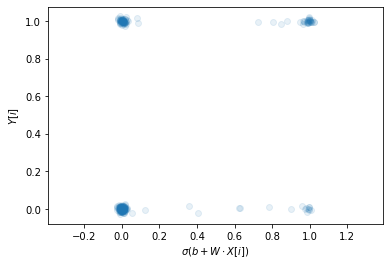

In [19]:
plt.scatter([1/(1+np.exp(-(S[0]+np.dot(S[1],X_test.iloc[i]))))+np.random.randn(1)/100 for i in range(n_test)]\
            ,[Y_test.iloc[i]+np.random.randn(1)/100 for i in range(n_test)]\
            ,alpha=0.1)
plt.xlabel('$\sigma(b+W\cdot X[i])$')
plt.ylabel('$Y[i]$')
plt.axis('equal')
plt.show

Calculs des erreurs de prédictions

In [20]:
maskv1=[Y_test.iloc[i]==1 for i in range(n_test)]
maskv0=[Y_test.iloc[i]==0 for i in range(n_test)]

# Prédictions
maskp1=[1/(1+np.exp(-(S[0]+np.dot(X_test.iloc[i],S[1]))))>0.5 for i in range(n_test)]
maskp0=[1/(1+np.exp(-(S[0]+np.dot(X_test.iloc[i],S[1]))))<=0.5 for i in range(n_test)]

# Erreurs
# Y=1 mais sigma(b+XW)<0.5 (Faux négatifs)
maske1=[(maskv1[i]==True and maskp1[i]==False) for i in range(len(maskv1))]
# Y=0 mais sigma(b+XW)>0.5 (Faux positifs)
maske0=[(maskv0[i]==True and maskp0[i]==False) for i in range(len(maskv0))]
# Y=1 et sigma(b+XW)>0.5 (Vrais positifs)
maskok1=[(maskv1[i]==True and maskp1[i]==True) for i in range(len(maskv1))]
# Y=0 et sigma(b+XW)<0.5 (Vrais négatifs)
maskok0=[(maskv0[i]==True and maskp0[i]==True) for i in range(len(maskv0))]
print("Erreur moyenne :",(np.count_nonzero(maske0)+np.count_nonzero(maske1))/n_test\
     ,'(score : ',1-(np.count_nonzero(maske0)+np.count_nonzero(maske1))/n_test,')'\
     ,'\n Vrai positifs :',np.count_nonzero(maskok1)
     ,'\n Faux positifs :',np.count_nonzero(maske0)\
     ,'\n Vrai négatifs :',np.count_nonzero(maskok0)\
     ,'\n Faux négatifs :',np.count_nonzero(maske1))

Erreur moyenne : 0.2920962199312715 (score :  0.7079037800687284 ) 
 Vrai positifs : 35 
 Faux positifs : 14 
 Vrai négatifs : 171 
 Faux négatifs : 71


# Utilisation d'une librairie

In [21]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='none').fit(X, Y)
#penalty='none' signifie qu'aucune régularisation n'est utilisée

Résultat :
- $W=(w_1,\ldots,w_d)$ est donné par reg.coef_
- $b$ est donné par reg.intercept_

In [22]:
print(reg.coef_,reg.intercept_)

[[-0.02963183 -1.10641864 -0.00356136  2.67392128]] [1.96292549]


Vérifions que le gradient est bien (presque) nul en $(b,W)$ :

In [23]:
print(df(1.9629254861476741,[-0.02963183,-1.10641864,-0.00356136,2.67392128]))

[0.0011951430203132052, 0.058927260105654966, 0.0019969858458803724, -0.05408536082837401, -0.001167945602113779]


En cette solution, notre algorithme converge en 1 passe avec une tolérance de 0.1 :

In [24]:
S=descente(df,1.9629254861476741,[-0.02963183,-1.10641864,-0.00356136,2.67392128],1e-9,1e-1,1)

L'algorithme a convergé.
 Solution atteinte:
 b= 1.9629254861476741 
 W= [-0.02963183, -1.10641864, -0.00356136, 2.67392128] 
 Gradient obtenu :
 [0.0011951430203132052, 0.058927260105654966, 0.0019969858458803724, -0.05408536082837401, -0.001167945602113779]


On peut même encore tenter d'améliorer la solution, mais est-ce utile ?

In [291]:
S=descente(df,S[0],S[1],1e-12,1e-2,10)

L'algorithme n'a pas convergé.
 Solution atteinte:
 b= 1.9629254861440681 
 W= [-0.029631830177958233, -1.1064186400060285, -0.003561359836711194, 2.6739212800035306] 
 Gradient obtenu :
 [0.0011951554493608851, 0.05892583369254112, 0.0019967608029087813, -0.05405183635489408, -0.0011679317049834714]


In [25]:
titanic=titanic.sample(frac=1).reset_index(drop=True)
Xinit=titanic.drop(['Survived','Male','Cherbourg','Queenstown','Southampton'],axis=1)
Yinit=titanic['Survived']
X=Xinit.iloc[:600]
Y=Yinit.iloc[:600]
n=len(X)
d=len(X.iloc[1])
X_test=Xinit.iloc[600:]
Y_test=Yinit.iloc[600:]
n_test=len(X_test)

In [26]:
from sklearn.neural_network import MLPClassifier
algo = MLPClassifier(activation='logistic', solver='sgd', hidden_layer_sizes=(6)\
                     ,max_iter=9000,tol=1e-40,random_state=1)
algo.fit(X,Y)

MLPClassifier(activation='logistic', hidden_layer_sizes=6, max_iter=9000,
              random_state=1, solver='sgd', tol=1e-40)

In [27]:
algo.score(X,Y)

0.765

<function matplotlib.pyplot.show(*args, **kw)>

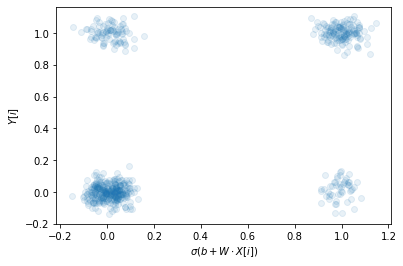

In [28]:
plt.scatter([algo.predict([X.iloc[i]])[0]+np.random.randn(1)/20 for i in range(n)]\
            ,[Y.iloc[i]+np.random.randn(1)/20 for i in range(n)]\
            ,alpha=0.1)
plt.xlabel('$\sigma(b+W\cdot X[i])$')
plt.ylabel('$Y[i]$')
plt.show

In [29]:
maskv1=[Y_test.iloc[i]==1 for i in range(n_test)]
maskv0=[Y_test.iloc[i]==0 for i in range(n_test)]

# Prédictions
maskp1=[algo.predict([X_test.iloc[i]])[0]>0.5 for i in range(n_test)]
maskp0=[algo.predict([X_test.iloc[i]])[0]<=0.5 for i in range(n_test)]

# Erreurs
# Y=1 mais sigma(b+XW)<0.5 (Faux négatifs)
maske1=[(maskv1[i]==True and maskp1[i]==False) for i in range(len(maskv1))]
# Y=0 mais sigma(b+XW)>0.5 (Faux positifs)
maske0=[(maskv0[i]==True and maskp0[i]==False) for i in range(len(maskv0))]
# Y=1 et sigma(b+XW)>0.5 (Vrais positifs)
maskok1=[(maskv1[i]==True and maskp1[i]==True) for i in range(len(maskv1))]
# Y=0 et sigma(b+XW)<0.5 (Vrais négatifs)
maskok0=[(maskv0[i]==True and maskp0[i]==True) for i in range(len(maskv0))]
print("Erreur moyenne :",(np.count_nonzero(maske0)+np.count_nonzero(maske1))/n_test\
     ,'(score : ',1-(np.count_nonzero(maske0)+np.count_nonzero(maske1))/n_test,')'\
     ,'\n Vrai positifs :',np.count_nonzero(maskok1)
     ,'\n Faux positifs :',np.count_nonzero(maske0)\
     ,'\n Vrai négatifs :',np.count_nonzero(maskok0)\
     ,'\n Faux négatifs :',np.count_nonzero(maske1))

Erreur moyenne : 0.28865979381443296 (score :  0.711340206185567 ) 
 Vrai positifs : 53 
 Faux positifs : 28 
 Vrai négatifs : 154 
 Faux négatifs : 56
